## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(len(nltk_data))
#print(nltk_data[:5])

3914


In [4]:
# Splitting into train and test into 95:5 ratio
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
#print(train_set[:5])

3718
196


In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95593

In [6]:
# Which is the most frequent tag in the corpus,frequency of elements in a list, the Counter() class from collections
from collections import Counter

tags = [pair[1] for pair in train_tagged_words]
tag_counts = Counter(tags)
tag_counts


Counter({'NOUN': 27424,
         '.': 11111,
         'ADP': 9363,
         'DET': 8291,
         'ADJ': 6064,
         'PRT': 3061,
         'VERB': 12888,
         'X': 6267,
         'PRON': 2601,
         'NUM': 3364,
         'ADV': 3018,
         'CONJ': 2141})

In [7]:
# Which word is most commonly assigned to the tag X
#x_tags = [pair for pair in train_tagged_words if pair[1].lower() == 'x']
#x_tags

In [8]:
# Which word is most commonly assigned to the tag X
prt_tags = [pair for pair in train_tagged_words if pair[1] == 'PRT']
prt_tags

[("'s", 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ("'s", 'PRT'),
 ("'s", 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('up', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ("'", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('away', 'PRT'),
 ('over', 'PRT'),
 ("'s", 'PRT'),
 ('To', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ("'s", 'PRT'),
 ('to', 'PRT'),
 ("'", 'PRT'),
 ('to', 'PRT'),
 ('to', 'PRT'),
 ('to'

In [9]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['INGERSOLL-RAND',
 'Co',
 '.',
 '-LRB-',
 'Woodcliff',
 'Lake',
 ',',
 'N.J',
 '.',
 '-RRB-']

In [10]:
# vocabulary
train_vocabulary_set = set(tokens)
print(len(train_vocabulary_set))


12056


In [11]:
# number of tags
tag_set = set([pair[1] for pair in train_tagged_words])
len(tag_set)

12

In [12]:
print(tag_set)

{'.', 'PRON', 'ADJ', 'PRT', 'ADP', 'CONJ', 'ADV', 'VERB', 'X', 'NUM', 'DET', 'NOUN'}


In [13]:
# computing P(w/t) and storing in T x V matrix
t = len(tag_set)
v = len(train_vocabulary_set)
w_given_t = np.zeros((t, v))

In [14]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

#Heatmap 
def plotheatmap(df,Title,Figsize=None):
    
    f,ax= plt.subplots(1,1,figsize=Figsize)   
    sns.heatmap(df,annot=True)
    ax.set_title(Title)
    
    #Fix 3.11 matplot version issue by setting the limits manually.
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    
    plt.show()

In [15]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tag_set), len(tag_set)), dtype='float32')
for i, t1 in enumerate(list(tag_set)):
    for j, t2 in enumerate(list(tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [16]:
#tags_matrix

In [17]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tag_set), index=list(tag_set))

In [18]:
tags_df

,.,PRON,ADJ,PRT,ADP,CONJ,ADV,VERB,X,NUM,DET,NOUN
.,0.094141,0.065791,0.043920,0.002520,0.091711,0.058051,0.052291,0.087931,0.027000,0.080281,0.172712,0.223562
PRON,0.041522,0.007689,0.072664,0.012687,0.021915,0.004614,0.034218,0.485198,0.093426,0.006920,0.009996,0.209150
ADJ,0.065139,0.000495,0.066623,0.010389,0.077836,0.016821,0.004617,0.012038,0.021603,0.021108,0.004947,0.698384
PRT,0.043450,0.017315,0.084613,0.001960,0.020908,0.002287,0.009474,0.402483,0.013068,0.057824,0.101601,0.245018
ADP,0.038342,0.068888,0.107337,0.001388,0.017089,0.000641,0.013137,0.008224,0.034284,0.063014,0.326818,0.320837
CONJ,0.035965,0.061186,0.119103,0.005138,0.053713,0.000467,0.054180,0.154601,0.008407,0.040635,0.119570,0.347034
ADV,0.134195,0.015242,0.128893,0.013917,0.121604,0.007290,0.080186,0.344930,0.022863,0.031146,0.068588,0.031146
VERB,0.034373,0.035692,0.065410,0.031425,0.090549,0.005354,0.082790,0.169770,0.217955,0.023045,0.133302,0.110335
X,0.163396,0.055529,0.017393,0.185575,0.143609,0.010212,0.026169,0.205042,0.074198,0.002713,0.054731,0.061433
NUM,0.117717,0.001486,0.033591,0.027943,0.035375,0.013971,0.002973,0.018728,0.208680,0.183413,0.003567,0.352556


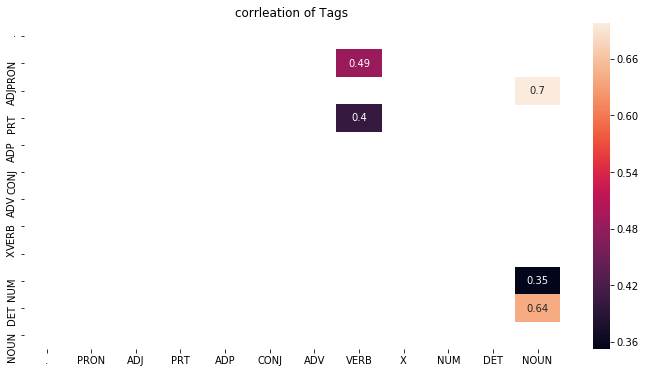

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.35
tags_frequent = tags_df[tags_df>0.35]
plotheatmap(tags_frequent,"corrleation of Tags",Figsize=(12, 6))


### Build the vanilla Viterbi based POS tagger

In [20]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(123)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
#test_run
rndom

[14, 69, 23, 105, 69]

In [21]:
rndom = [random.randint(1,len(test_set)) for x in range(5)]
rndom

#[9, 172, 178, 22, 26]
#[91, 61, 5, 8, 5]
#[113, 30, 2, 24, 150]   - 98.3
#[88, 68, 15, 149, 106]  - 91.6
#[38, 118, 117, 45, 181] - 88.24, 89.8
#[104, 98, 52, 154, 46] - 96

[28, 10, 98, 138, 144]

In [22]:
# Viterbi Heuristic
def Viterbi_Vanilla(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [23]:
#Function to check accuracy
def check_accuracy(tagged_set, test_run_base,msg):
    check = [i for i, j in zip(tagged_set, test_run_base) if i == j] 
    accuracy = round((len(check)/len(tagged_set))*100,2)
    print(msg,accuracy)

In [24]:
#Test on Vanilla Viterbi model
start = time.time()
tagged_set1 = Viterbi_Vanilla(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))
check_accuracy(tagged_set1,test_run_base,'Accuracy of Viterbi Vanilla model: ')


Time taken in seconds:  53.11
Accuracy of Viterbi Vanilla model:  88.67


In [25]:
#print(tagged_seq)
#print(test_run_base)

In [26]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_set1, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('to', 'PRT'), (('position', 'NOUN'), ('position', 'VERB'))],
 [('failed', 'VERB'),
  (('labor-management', 'ADJ'), ('labor-management', 'NOUN'))],
 [('was', 'VERB'), (('kind', 'NOUN'), ('kind', 'ADJ'))],
 [('and', 'CONJ'), (('playful', '.'), ('playful', 'ADJ'))],
 [('was', 'VERB'), (('dreadful', '.'), ('dreadful', 'ADJ'))],
 [('her', 'PRON'), (('war-damaged', '.'), ('war-damaged', 'ADJ'))],
 [('her', 'PRON'), (('lover', '.'), ('lover', 'NOUN'))],
 [('indicators', 'NOUN'), (('gauges', '.'), ('gauges', 'VERB'))],
 [('a', 'DET'), (('worsening', '.'), ('worsening', 'NOUN'))],
 [('*U*', 'X'), (('write-off', '.'), ('write-off', 'NOUN'))],
 [('capitalized', 'VERB'), (('servicing', 'VERB'), ('servicing', 'NOUN'))],
 [('home', 'NOUN'), (('financing', 'NOUN'), ('financing', 'VERB'))],
 [('was', 'VERB'), (('kind', 'NOUN'), ('kind', 'ADJ'))],
 [('and', 'CONJ'), (('playful', '.'), ('playful', 'ADJ'))],
 [('was', 'VERB'), (('dreadful', '.'), ('dreadful', 'ADJ'))],
 [('her', 'PRON'), (('war-damage

* All unknown numbers are tagged as ADJ instead of NUM
* All unknown words are tagged as ADJ since its the first tag. 
* As heat map suggests most of the DET is followed by NOUN, hence we can add this rule to Vanilla viterbi logic


### Solve the problem of unknown words

In [27]:
# list all unknown words in test set compared to train set.

test_tagged_set = set([t for t in test_tagged_words])
train_tagged_set = set([t for t in train_tagged_words])

unknown_words = list(test_tagged_set - train_tagged_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 91


Unknown Words : ['*T*-1', '0', 'been', 'position', 'playful', 'said', ';', 'capitalized', "'s", 'is', 'help', 'which', 'million', 'financing', 'and', 'write-off', 'she', 'into', 'mobile', 'to', 'was', '$', 'at', 'subsidiary', 'as', 'Stephen', 'brought', 'number', 'Steinberg', 'difference', 'himself', 'friendly', 'lover', 'husband', 'gauges', 'Wolf', 'reporting', 'their', 'Although', 'on', 'who', 'UAL', 'drain', 'home', 'could', 'children', 'investment', 'openly', 'survey', '*-2', 'her', 'earnings', 'worsening', 'a', ',', 'revive', 'Mr.', '.', 'Each', 'bid', 'investor', 'labor-management', '*U*', 'war-damaged', 'big', 'between', 'improvement', 'may', 'the', '62', 'dreadful', 'be', 'bulk', 'in', 'particular', 'kind', 'The', 'banker', 'indicators', 'charge', 'of', 'failed', 'trying', 'purchasers', 'pretax', 'servicing', 'had', 'One', 'Chairman', 'area', 'company']


In [28]:
### Method 1

In [29]:
# Modification of vanilla Viterbi Heuristic algorithm.
def Viterbi_m1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # If word in unknown then consider only the transition_p 
            
            if word not in train_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
            
            
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [30]:
#Test on modified Viterbi model
start = time.time()
tagged_set2 = Viterbi_m1(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))
check_accuracy(tagged_set2,test_run_base,'Accuracy of Modified Viterbi model: ')


Time taken in seconds:  51.27
Accuracy of Modified Viterbi model:  89.33


In [31]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_set2, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('to', 'PRT'), (('position', 'NOUN'), ('position', 'VERB'))],
 [('failed', 'VERB'),
  (('labor-management', 'ADJ'), ('labor-management', 'NOUN'))],
 [('was', 'VERB'), (('kind', 'NOUN'), ('kind', 'ADJ'))],
 [('and', 'CONJ'), (('playful', 'NOUN'), ('playful', 'ADJ'))],
 [('was', 'VERB'), (('dreadful', 'X'), ('dreadful', 'ADJ'))],
 [('her', 'PRON'), (('war-damaged', 'VERB'), ('war-damaged', 'ADJ'))],
 [('her', 'PRON'), (('lover', 'VERB'), ('lover', 'NOUN'))],
 [('indicators', 'NOUN'), (('gauges', 'NOUN'), ('gauges', 'VERB'))],
 [('*U*', 'X'), (('write-off', 'VERB'), ('write-off', 'NOUN'))],
 [('capitalized', 'VERB'), (('servicing', 'VERB'), ('servicing', 'NOUN'))],
 [('home', 'NOUN'), (('financing', 'NOUN'), ('financing', 'VERB'))],
 [('was', 'VERB'), (('kind', 'NOUN'), ('kind', 'ADJ'))],
 [('and', 'CONJ'), (('playful', 'NOUN'), ('playful', 'ADJ'))],
 [('was', 'VERB'), (('dreadful', 'X'), ('dreadful', 'ADJ'))],
 [('her', 'PRON'), (('war-damaged', 'VERB'), ('war-damaged', 'ADJ'))],
 [('h

In [32]:
patterns = [
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

# rule based RegexpTagger
rule_based_tagger = nltk.RegexpTagger(patterns)

### Model 2

In [33]:
# Modification of Viterbi Heuristic algorithm to include 
def Viterbi_m2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        num_word=re.search('^[0-9]*.?[0-9]*[0-9]$',word)
        
        if num_word and word not in train_vocabulary_set:
            state.append('NUM')
        else:
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
                # modification to the original vanilla viterbi algorithm 
                # If word in unknown then consider only the transition_p 
            
                if word not in train_vocabulary_set:
                
                    state_probability = transition_p
                else:
                    state_probability = emission_p * transition_p
            
            
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


In [34]:
#Test on modified Viterbi model
start = time.time()
tagged_set3 = Viterbi_m2(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))
check_accuracy(tagged_set3,test_run_base,'Accuracy of Modified Viterbi Model 2: ')

 tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)
# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]
viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)#

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

Time taken in seconds:  51.5
Accuracy of Modified Viterbi Model 2:  89.33


In [35]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_set3, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('to', 'PRT'), (('position', 'NOUN'), ('position', 'VERB'))],
 [('failed', 'VERB'),
  (('labor-management', 'ADJ'), ('labor-management', 'NOUN'))],
 [('was', 'VERB'), (('kind', 'NOUN'), ('kind', 'ADJ'))],
 [('and', 'CONJ'), (('playful', 'NOUN'), ('playful', 'ADJ'))],
 [('was', 'VERB'), (('dreadful', 'X'), ('dreadful', 'ADJ'))],
 [('her', 'PRON'), (('war-damaged', 'VERB'), ('war-damaged', 'ADJ'))],
 [('her', 'PRON'), (('lover', 'VERB'), ('lover', 'NOUN'))],
 [('indicators', 'NOUN'), (('gauges', 'NOUN'), ('gauges', 'VERB'))],
 [('*U*', 'X'), (('write-off', 'VERB'), ('write-off', 'NOUN'))],
 [('capitalized', 'VERB'), (('servicing', 'VERB'), ('servicing', 'NOUN'))],
 [('home', 'NOUN'), (('financing', 'NOUN'), ('financing', 'VERB'))],
 [('was', 'VERB'), (('kind', 'NOUN'), ('kind', 'ADJ'))],
 [('and', 'CONJ'), (('playful', 'NOUN'), ('playful', 'ADJ'))],
 [('was', 'VERB'), (('dreadful', 'X'), ('dreadful', 'ADJ'))],
 [('her', 'PRON'), (('war-damaged', 'VERB'), ('war-damaged', 'ADJ'))],
 [('h

### Model 3

In [37]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is - 0.8998622860515444


In [ ]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [38]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.908715325595121


In [39]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is -", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is - 0.9118630729883926


In [40]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9120598072004722


In [41]:
def trigram_tagger(word, train_set = train_set):
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)
    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [45]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in train_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [46]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9466666666666667


#### Evaluating tagging accuracy

In [ ]:
f = open('Test_sentences.txt')
text = f.read()
sample_test_sent = text.splitlines()
f.close()
sample_test_sent

In [ ]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]

In [ ]:
# tagging the test sentences
start = time.time()
tagged_seq_tst = Viterbi_m2(sample_test_words)
end = time.time()


In [ ]:
tagged_seq_tst

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications